# Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
%matplotlib inline

crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

crime.columns = ['city', 'population', 'violent_crime', 
                 'murder','rape_revised','rape_legacy',
                 'robbery','aggravated_assault','property_crime',
                 'burglary', 'larceny_theft','motor_vehicle_theft','arson' ]
crime['population_squared'] = crime.population**2
crime = crime.drop(columns=['rape_revised'])
#crime['murder_cat'] = if crime['murder'] > 0 return 1, else 0
#crime['robbery_cat'] =
crime = crime.dropna()

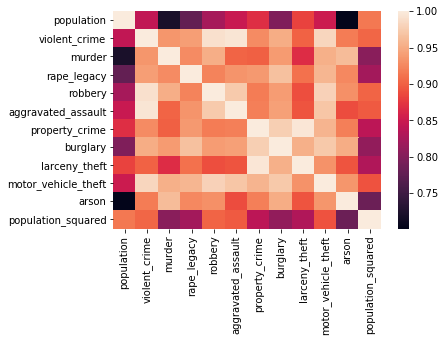

In [3]:
sns.heatmap(crime.corr())
plt.show()

In [4]:
# Removing outliers
def within_x_std(col,x):
    mean = crime[col].mean()
    x_std = crime[col].std()*x
    upper_bound = mean + x_std
    lower_bound = mean - x_std
    return [upper_bound,lower_bound]

population_bounds = within_x_std("population",3)
larceny_bounds = within_x_std("larceny_theft",3)
murder_bounds = within_x_std("murder",3)
robbery_bounds = within_x_std("robbery",3)
burglary_bounds = within_x_std("burglary",3)
arson_bounds = within_x_std("arson",3)
assault_bounds = within_x_std("aggravated_assault",3)
rape_bounds = within_x_std("rape_legacy",3)
violent_crime_bounds = within_x_std("violent_crime",3)

crime = crime[(crime['population'] <= population_bounds[0]) & (crime['population'] >= population_bounds[1])]
crime = crime[(crime['larceny_theft'] <= larceny_bounds[0]) & (crime['larceny_theft'] >= larceny_bounds[1])]
crime = crime[(crime['murder'] <= murder_bounds[0]) & (crime['murder'] >= murder_bounds[1])]
crime = crime[(crime['robbery'] <= robbery_bounds[0]) & (crime['robbery'] >= robbery_bounds[1])]
crime = crime[(crime['burglary'] <= burglary_bounds[0]) & (crime['burglary'] >= burglary_bounds[1])]
crime = crime[(crime['arson'] <= arson_bounds[0]) & (crime['arson'] >= arson_bounds[1])]
crime = crime[(crime['aggravated_assault'] <= assault_bounds[0]) & (crime['aggravated_assault'] >= assault_bounds[1])]
crime = crime[(crime['rape_legacy'] <= rape_bounds[0]) & (crime['rape_legacy'] >= rape_bounds[1])]
crime = crime[(crime['violent_crime'] <= violent_crime_bounds[0]) & (crime['violent_crime'] >= violent_crime_bounds[1])]


/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


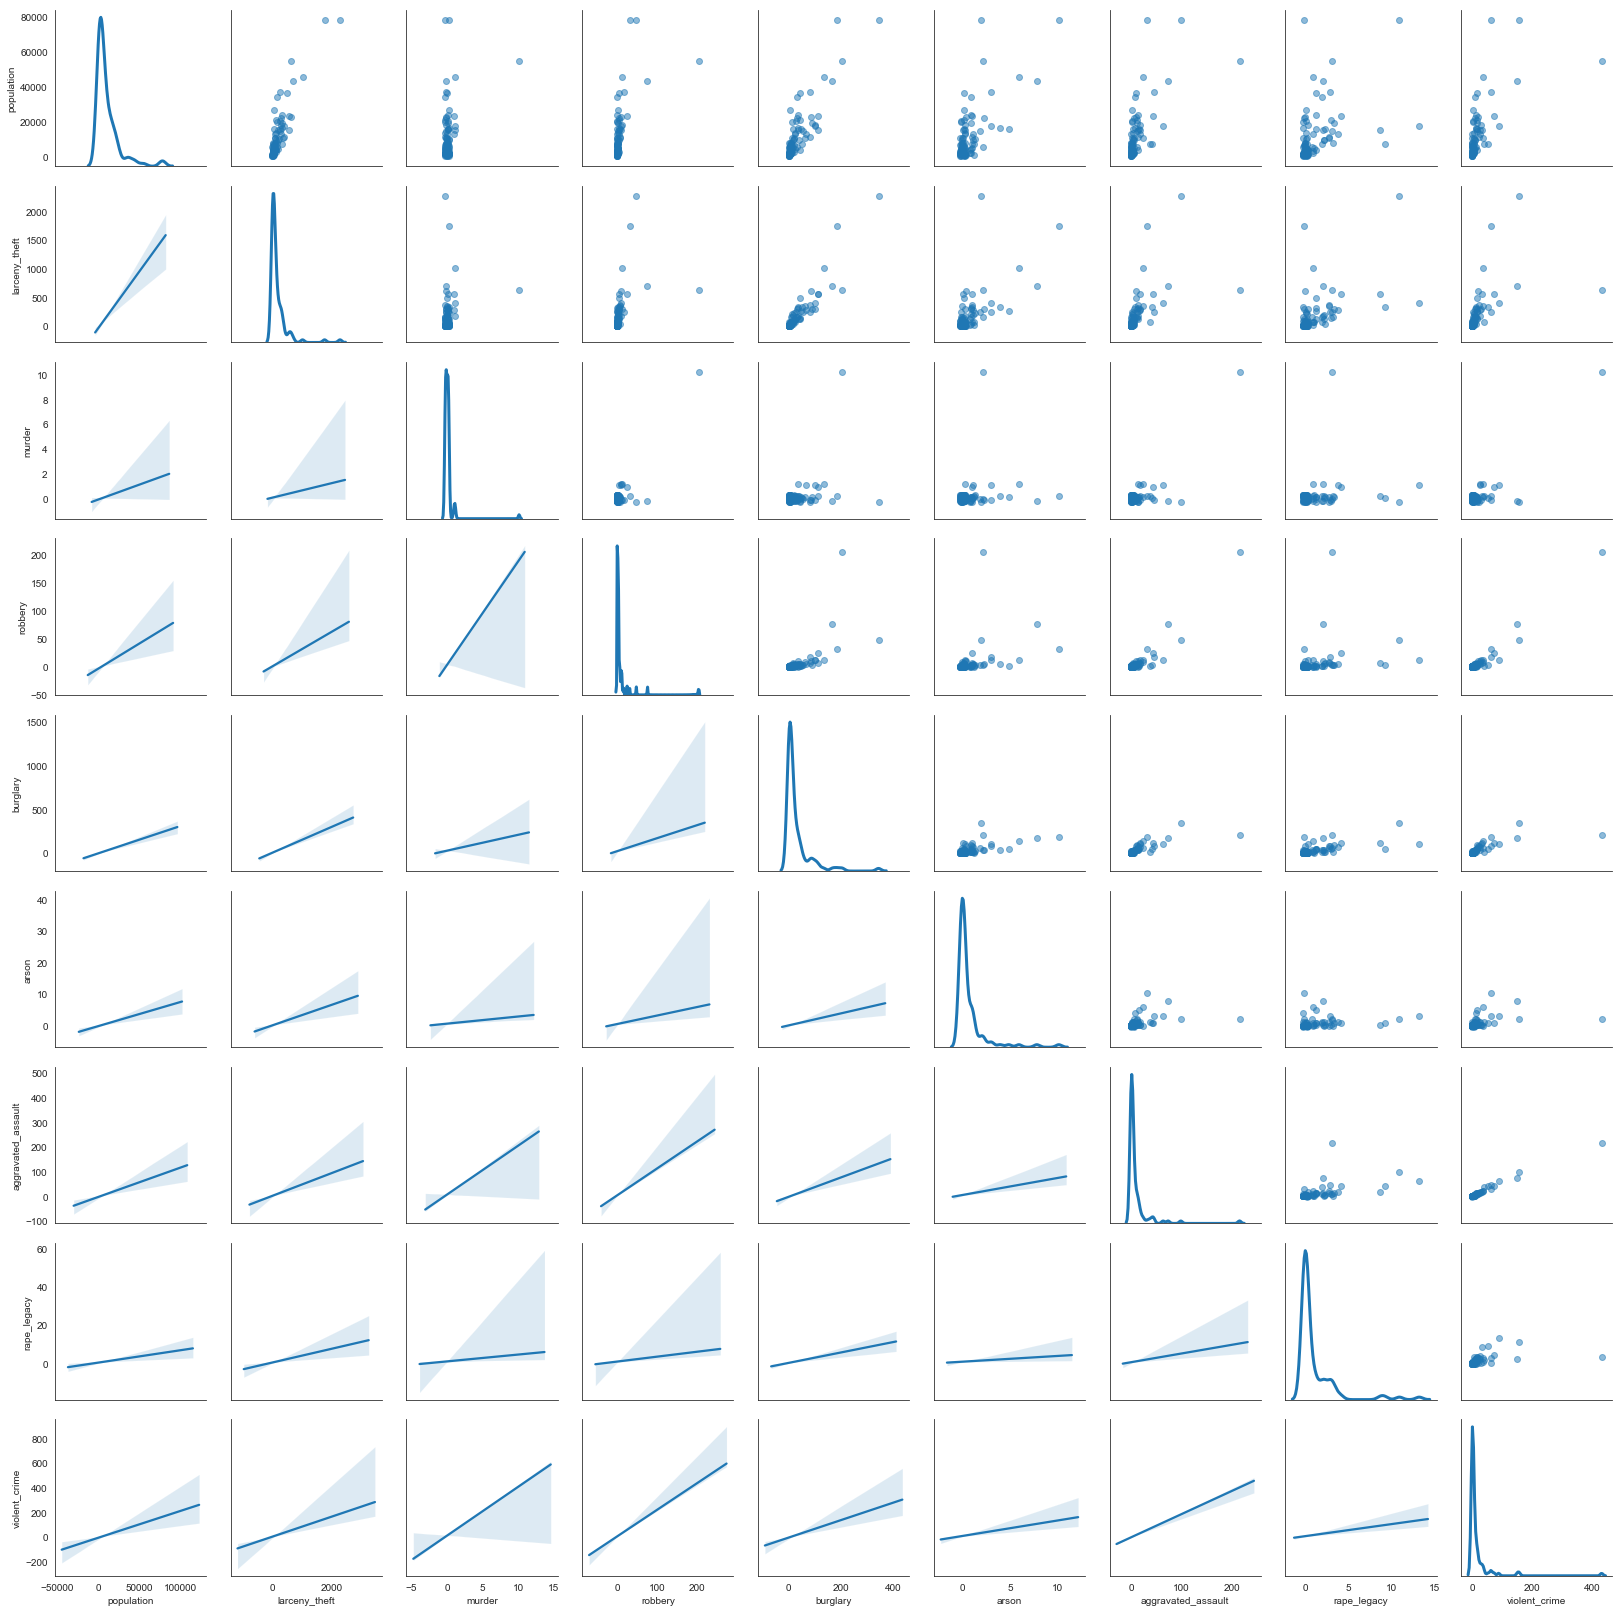

In [5]:
# Make the scatterplot matrix
# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Take a subset of the data to make plots clearer.
crime_sel = crime[['property_crime', 'population', 'larceny_theft', 'murder', 'robbery','burglary','arson','aggravated_assault','rape_legacy','violent_crime']]

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
crime_jittered = crime_sel.loc[:, 'population':'violent_crime'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_jittered.shape)),
    columns=crime_jittered.columns
)

# Combine the data and the noise.
crime_jittered = crime_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(crime_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

#Some warnings will show up below because the plot does not include a legend.

In [36]:
x_2013 = crime[['population','larceny_theft','murder','robbery','burglary','arson','aggravated_assault','rape_legacy','violent_crime']]
y_2013 = crime['property_crime']

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x_2013, y_2013)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [ 2.15139814e-04  1.01181187e+00  6.39189231e-01  2.28998084e-01
  1.02163479e+00 -3.26055994e-01 -5.42901836e-01  4.08388534e-02
  3.66124332e-01]
Intercept: 
 -0.7701665438506495


In [37]:
regr.score(x_2013,y_2013)

0.9998826068803143

In [38]:
# with statsmodels
x_2013 = sm.add_constant(x_2013) # adding a constant
 
model = sm.OLS(y_2013, x_2013).fit()
predictions = model.predict() 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.842e+05
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:16:33   Log-Likelihood:                -512.35
No. Observations:                 182   AIC:                             1043.
Df Residuals:                     173   BIC:                             1072.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7702      0

In [39]:
crime_2014 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', header=4)

crime_2014.columns = ['city', 'population', 'violent_crime', 
                 'murder','rape_revised','rape_legacy',
                 'robbery','aggravated_assault','property_crime',
                 'burglary', 'larceny_theft','motor_vehicle_theft','arson' ]
#crime_2014['population_squared'] = crime.population**2
crime_2014 = crime_2014.drop(columns=['rape_revised'])
crime_2014 = crime_2014.dropna()


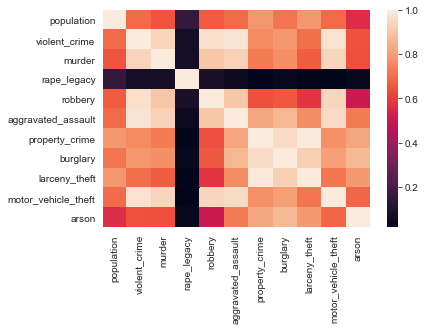

In [40]:
sns.heatmap(crime_2014.corr())
plt.show()

In [41]:
# Removing outliers
def within_x_std(data,col,x):
    mean = data[col].mean()
    x_std = data[col].std()*x
    upper_bound = mean + x_std
    lower_bound = mean - x_std
    return [upper_bound,lower_bound]

population_bounds = within_x_std(crime_2014,"population",3)
larceny_bounds = within_x_std(crime_2014,"larceny_theft",3)
murder_bounds = within_x_std(crime_2014,"murder",3)
robbery_bounds = within_x_std(crime_2014,"robbery",3)
burglary_bounds = within_x_std(crime_2014,"burglary",3)
arson_bounds = within_x_std(crime_2014,"arson",3)
assault_bounds = within_x_std(crime_2014,"aggravated_assault",3)
rape_bounds = within_x_std(crime_2014,"rape_legacy",3)
violent_crime_bounds = within_x_std(crime_2014,"violent_crime",3)

crime_2014 = crime_2014[(crime_2014['population'] <= population_bounds[0]) & (crime_2014['population'] >= population_bounds[1])]
crime_2014 = crime_2014[(crime_2014['larceny_theft'] <= larceny_bounds[0]) & (crime_2014['larceny_theft'] >= larceny_bounds[1])]
crime_2014 = crime_2014[(crime_2014['murder'] <= murder_bounds[0]) & (crime_2014['murder'] >= murder_bounds[1])]
crime_2014 = crime_2014[(crime_2014['robbery'] <= robbery_bounds[0]) & (crime_2014['robbery'] >= robbery_bounds[1])]
crime_2014 = crime_2014[(crime_2014['burglary'] <= burglary_bounds[0]) & (crime_2014['burglary'] >= burglary_bounds[1])]
crime_2014 = crime_2014[(crime_2014['arson'] <= arson_bounds[0]) & (crime_2014['arson'] >= arson_bounds[1])]
crime_2014 = crime_2014[(crime_2014['aggravated_assault'] <= assault_bounds[0]) & (crime_2014['aggravated_assault'] >= assault_bounds[1])]
crime_2014 = crime_2014[(crime_2014['rape_legacy'] <= rape_bounds[0]) & (crime_2014['rape_legacy'] >= rape_bounds[1])]
crime_2014 = crime_2014[(crime_2014['violent_crime'] <= violent_crime_bounds[0]) & (crime_2014['violent_crime'] >= violent_crime_bounds[1])]


In [42]:
x_2014 = crime[['population','larceny_theft','murder','robbery','burglary','arson','aggravated_assault','rape_legacy','violent_crime']]
y_2014 = crime['property_crime']

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x_2014, y_2014)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [ 2.15139814e-04  1.01181187e+00  6.39189231e-01  2.28998084e-01
  1.02163479e+00 -3.26055994e-01 -5.42901836e-01  4.08388534e-02
  3.66124332e-01]
Intercept: 
 -0.7701665438506495


In [43]:
regr.score(x_2014,y_2014)

0.9998826068803143

In [44]:
data = x_2014
target = y_2013

from sklearn.linear_model import Lasso
lasso = Lasso()

y_pred = lasso.fit(data, target).predict(data)

from sklearn.model_selection import cross_val_score
cross_val_score(lasso, data, target, cv=10)

array([0.99987064, 0.99997026, 0.99971927, 0.99983484, 0.99887207,
       0.99984469, 0.99967439, 0.99947415, 0.99950961, 0.99987983])

In [45]:
from sklearn.model_selection import train_test_split
data = x_2014
target = y_2013

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(lasso.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(lasso.fit(data, target).score(data, target)))


With 20% Holdout: 0.9998262871294109
Testing on Sample: 0.9998770962168099
